In [1]:
import os
import sys
import numpy as np
import hydra

from cliport.dataset import RavensDataset
from cliport.utils import utils
from cliport import tasks
from cliport.environments.environment import Environment
import clip
from PIL import Image
import torch

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


text = clip.tokenize(["pack the red block in the brown box", "stack the red block on the middle brown block", "put the red block in a white bowl", "stack the yellow block on the green block"]).to(device)
action = clip.tokenize(["pack in", "stack on", "put in"]).to(device)
with torch.no_grad():
    text_features = model.encode_text(text)
    action_features = model.encode_text(action)
    
similarity = (100.0 * text_features @ action_features.T).softmax(dim=-1)    
print(similarity)
    

tensor([[9.9951e-01, 0.0000e+00, 3.3545e-04],
        [0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]], device='cuda:0',
       dtype=torch.float16)


In [28]:
### task settings
mode = 'test'
augment = True

### Uncomment the task you want to generate ###
#task = 'stack-block-pyramid-seq-seen-colors'
#task = 'packing-shapes-train'
task = 'packing-stacking-putting-same-objects'

### visualization settings
max_episodes = 1
max_steps = 100

In [29]:
# Load configs
root_dir = '/home/jerrylin/temp/cliport'
config_file = 'train.yaml' 
cfg = utils.load_hydra_config(os.path.join(root_dir, f'cliport/cfg/{config_file}'))

# Override defaults
cfg['task'] = task
cfg['mode'] = mode

data_dir = os.path.join(root_dir, 'data')

In [30]:
task = tasks.names[cfg['task']]()
task.mode = mode

ds = RavensDataset(os.path.join(data_dir, f'{cfg["task"]}-{cfg["mode"]}'), cfg, augment=augment)

stack the purple block on the lightest brown block
stack the red block on the middle brown block
pack the white block in the brown box
pack the orange block in the brown box
stack the pink block on the purple and red blocks
put the green block in a purple bowl
put the blue block in a red bowl
task completed.


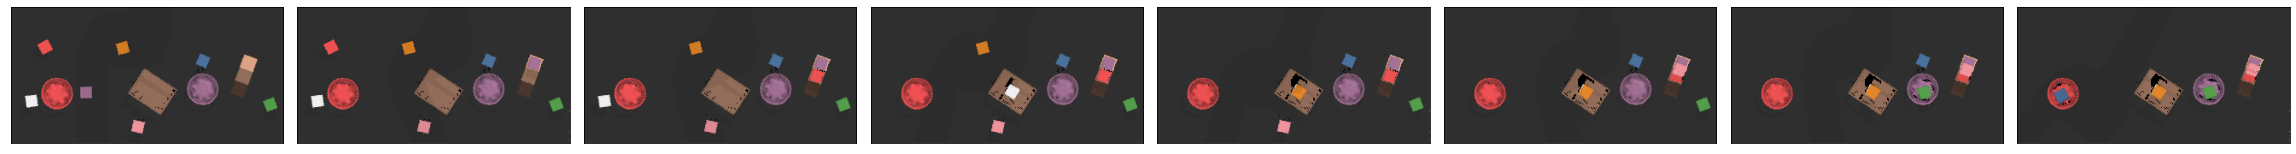

In [35]:
total_images = 0

episode, seed = ds.load(0)

total_images += len(episode)-1

total_reward = 0

fig = plt.figure(figsize=(32, 32))
columns = len(episode)
rows = 1
episode_images = []
episode_descrptions = []
for step in range(min(max_steps, len(episode))):
    obs, act, reward, info, embedding = episode[step]

    num_images = len(obs['color'])
    
    cam_config = None
    if b'camera_info' in info:
        cam_config = ds.get_cam_config(info[b'camera_info'])
    
    img_depth = ds.get_image(obs, cam_config=cam_config)
    img_tensor = torch.from_numpy(img_depth)
    img = np.uint8(img_tensor.detach().cpu().numpy())
    img = img.transpose(1,0,2)
    
    if step < len(episode)-1 and episode[step]:
        batch = ds.process_sample(episode[step], augment=None)
    else:
        batch = ds.process_goal(episode[step], perturb_params=None)

    img_sample = batch['img']
    img_sample = torch.from_numpy(img_sample)
    color = np.uint8(img_sample.detach().cpu().numpy())[:,:,:3]
    color = color.transpose(1,0,2)
    episode_images.append(color)
    episode_descrptions.append(batch['lang_goal'])
    print(batch['lang_goal'])
    fig.add_subplot(rows, columns, step + 1)
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(color)
    
plt.tight_layout()
plt.show()


In [ ]:
def convert_action_description_to_pre_and_post_conditions(text):
    text_tokens = text.split()
    text_tokens = text_tokens[1:]
    text_tokens = ' '.join(text_tokens)
    return text_tokens

In [ ]:
processed_text = []
for i in range(len(episode_descrptions)-1):
    processed_text.append(convert_action_description_to_pre_and_post_conditions(episode_descrptions[i]))

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

processed_images = []
for i in range(len(episode_images)):
    image = preprocess(Image.fromarray(np.uint8(episode_images[i]))).unsqueeze(0).to(device)
    processed_images.append(image)
processed_images = torch.cat(processed_images)
text = clip.tokenize(processed_text).to(device)

with torch.no_grad():
    logits_per_image, logits_per_text = model(processed_images, text)
    probs = logits_per_text.softmax(dim=-1).cpu().numpy()

print(probs)

In [ ]:
processed_text

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

processed_images = []
for i in range(len(episode_images)):
    image = preprocess(Image.fromarray(np.uint8(episode_images[i]))).unsqueeze(0).to(device)
    processed_images.append(image)
processed_images = torch.cat(processed_images)
text = clip.tokenize(episode_descrptions).to(device)

with torch.no_grad():
    logits_per_image, logits_per_text = model(processed_images, text)
    probs = logits_per_text.softmax(dim=-1).cpu().numpy()

print(probs)

In [ ]:
episode_descrptions